In [2]:
import h5py
import dotenv
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
import fastmri
import fastmri.data.transforms as T
import fastmri.data
import fastmri.data.subsample
from fastmri.evaluate import ssim, psnr
import torch
import cv2

In [3]:
dotenv.load_dotenv()

SINGLECOIL_TRAIN_PATH = os.environ.get('SINGLECOIL_TRAIN_PATH')
SINGLECOIL_VAL_PATH = os.environ.get('SINGLECOIL_VAL_PATH')

print(f'SINGLECOIL_TRAIN_PATH: {SINGLECOIL_TRAIN_PATH}')
print(f'SINGLECOIL_VAL_PATH: {SINGLECOIL_VAL_PATH}')


SINGLECOIL_TRAIN_PATH: /home/alek/ml_data/knee_singlecoil_val/singlecoil_train
SINGLECOIL_VAL_PATH: /home/alek/ml_data/knee_singlecoil_val/singlecoil_val


In [4]:
train_files = glob.glob(os.path.join(SINGLECOIL_TRAIN_PATH, '*.h5'))

# file_name = 'multicoil_train/file1000167.h5'
# file_name = '/Users/rohitkapoor/Downloads/singlecoil_train/file1002073.h5'
file_name = train_files[0]
hf = h5py.File(file_name)

In [12]:
kspace = hf['kspace'][()]
kspace = T.to_tensor(kspace)
print(kspace.dtype)
print(kspace.shape)
sample_idx = kspace.shape[0] // 2

torch.float32
torch.Size([33, 640, 372, 2])


In [13]:
center_fraction = 0.04
accelerations = 8

W=320
H=320

In [14]:
kspace = T.complex_center_crop(kspace, (W, H))
kspace_abs = fastmri.complex_abs(kspace)
kspace_abs.shape

torch.Size([33, 320, 320])

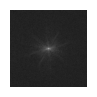

In [15]:
figsize=(1,1)
plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(torch.pow(kspace_abs[sample_idx],0.25), cmap='gray')
plt.margins(0,0)
# plt.savefig('images/img1.png', bbox_inches='tight', dpi=300)
plt.show()

In [16]:
img = fastmri.ifft2c(kspace)
img_abs = fastmri.complex_abs(img)

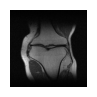

In [17]:
plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(img_abs[sample_idx], cmap='gray')
# plt.savefig('images/img1.png', bbox_inches='tight', dpi=300)
plt.show()

In [20]:


kspace_img = torch.pow(kspace_abs[sample_idx], 0.25)
kspace_img = (kspace_img / kspace_img.max() * 255).byte().cpu().numpy()      # 0‒255 uint8
kspace_img_colored = cv2.applyColorMap(kspace_img, cv2.COLORMAP_HOT)      # adds colormap
cv2.imwrite('images/knee_kspace.png', kspace_img_colored)

img_cv2 = (img_abs[sample_idx] / img_abs[sample_idx].max() * 255).byte().cpu().numpy()
cv2.imwrite('images/knee_img.png', img_cv2)

True

In [21]:
mask_func = fastmri.data.subsample.RandomMaskFunc(center_fractions=[center_fraction], accelerations=[accelerations])
masked_kspace, mask, _ = T.apply_mask(kspace, mask_func)

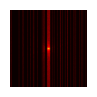

In [23]:
masked_kspace_abs = fastmri.complex_abs(masked_kspace)
plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(torch.pow(masked_kspace_abs[sample_idx],0.25), cmap='hot')
plt.show()

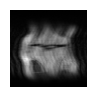

In [24]:
recon_img = fastmri.ifft2c(masked_kspace)
recon_img_abs = fastmri.complex_abs(recon_img)
plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(recon_img_abs[sample_idx], cmap='gray')
plt.show()

In [25]:
masked_kspace_img = torch.pow(masked_kspace_abs[sample_idx], 0.25)
masked_kspace_img = (masked_kspace_img / masked_kspace_img.max() * 255).byte().cpu().numpy()      # 0‒255 uint8
masked_kspace_img_colored = cv2.applyColorMap(masked_kspace_img, cv2.COLORMAP_HOT)      # adds colormap
cv2.imwrite('images/knee_masked_kspace.png', masked_kspace_img_colored)

recon_img_cv2 = (recon_img_abs[sample_idx] / recon_img_abs[sample_idx].max() * 255).byte().cpu().numpy()
cv2.imwrite('images/knee_recon_img.png', recon_img_cv2)

True

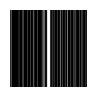

In [26]:
plt.figure(figsize=figsize)
plt.gca().set_axis_off()
plt.imshow(mask.repeat(1,320,1,1).squeeze(), cmap='gray') # mask is (1,1,W,1) -> 
plt.show()

In [27]:
mask_img = (mask.repeat(1,320,1,1).squeeze() * 255).byte().cpu().numpy()
cv2.imwrite('images/knee_mask.png', mask_img)

True